In [138]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
from sklearn.decomposition import PCA 

# --- FUNGSI PLOT YANG SUDAH DITINGKATKAN ---

def plot_silhouette_with_pca(X, n_clusters, labels, silhouette_avg, sample_silhouette_values, X_pca, centers_pca, pca_explained_variance):
    """
    Memvisualisasikan Silhouette Plot dan Scatter Plot PCA untuk hasil clustering.
    
    Argumen:
        X (np.array/pd.DataFrame): Data fitur mentah/scaled (tergantung yang digunakan untuk clustering).
        n_clusters (int): Jumlah cluster yang ditemukan (tidak termasuk noise -1).
        labels (np.array): Label cluster dari model (termasuk noise -1 jika dari DBSCAN).
        silhouette_avg (float): Skor silhouette rata-rata.
        sample_silhouette_values (np.array): Nilai silhouette untuk setiap sampel (HANYA non-noise untuk DBSCAN).
        X_pca (np.array): Data yang sudah direduksi dimensi ke 2D (termasuk noise untuk DBSCAN).
        centers_pca (np.array): Posisi centroid/mean cluster di ruang PCA.
        pca_explained_variance (np.array): Explained variance ratio dari PCA.
    """

    if isinstance(X, (pd.DataFrame, pd.Series)):
        X = X.values
    
    # Filter data HANYA untuk yang memiliki label cluster valid (>= 0)
    non_noise_mask = labels >= 0
    X_plot_non_noise = X[non_noise_mask] # Data non-noise untuk batas y Silhouette
    X_pca_non_noise = X_pca[non_noise_mask] # Data PCA non-noise untuk scatter
    labels_non_noise = labels[non_noise_mask]
    
    # Cek jika ada data non-noise yang cukup untuk visualisasi silhouette
    if n_clusters < 2 or len(X_plot_non_noise) < 2 or len(sample_silhouette_values) == 0:
        print("Tidak ada cukup cluster atau sampel non-noise untuk memplot Silhouette.")
        return

    # Inisialisasi subplot
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # --- Plot 1: Silhouette Plot (ax1) ---
    ax1.set_xlim([-0.1, 1])
    # Batas Y dihitung berdasarkan jumlah sampel NON-NOISE
    ax1.set_ylim([0, len(X_plot_non_noise) + (n_clusters + 1) * 10]) 

    y_lower = 10
    
    # Loop HANYA pada label cluster yang valid (0 hingga n_clusters-1)
    for i in range(n_clusters):
        # Ambil nilai silhouette untuk cluster ke-i dari nilai sampel yang sudah di-mask
        ith_cluster_silhouette_values = sample_silhouette_values[labels_non_noise == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i) / n_clusters)
        
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
            facecolor=color, edgecolor=color, alpha=0.7,
        )

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10

    ax1.set_title(f"The Silhouette Plot for {n_clusters} Clusters (Non-Noise)")
    ax1.set_xlabel("The Silhouette Coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])


    # --- Plot 2: Visualisasi Cluster PCA (ax2) ---
    # 1. Scatter plot data (Menggunakan SEMUA data X_pca, termasuk noise)
    # Tujuannya untuk melihat sebaran noise (-1)
    
    # Buat array warna untuk SEMUA sampel, termasuk noise
    # Noise (-1) akan diberi warna hitam/abu-abu
    colors_full = np.empty(len(X_pca), dtype=object)
    
    for i in range(n_clusters):
        colors_full[labels == i] = cm.nipy_spectral(float(i) / n_clusters)
        
    # Beri warna khusus untuk noise (-1)
    colors_full[labels == -1] = 'grey'
    
    ax2.scatter(
        X_pca[:, 0], X_pca[:, 1], 
        marker="o", s=50, lw=0, alpha=0.7, # S=50 di sini lebih terlihat
        c=colors_full, edgecolor="k"
    )
    
    # 2. Gambar centroid (Menggunakan centers_pca yang hanya non-noise)
    # Centroid/Mean hanya dihitung untuk cluster yang valid
    ax2.scatter(
        centers_pca[:, 0],
        centers_pca[:, 1],
        marker="o", 
        lw=1,
        c="white",
        alpha=1,
        s=200, # Perbesar ukuran centroid agar terlihat jelas
        edgecolor="k",
        zorder=10 # Pastikan centroid di atas titik data
    )

    # Label Centroid
    for i, c_pca in enumerate(centers_pca):
        ax2.scatter(c_pca[0], c_pca[1], marker=f"${i}$", alpha=1, s=80, color='black', zorder=11) 
        # Marker $i$ di sini diubah menjadi s=80 agar lebih jelas

    ax2.set_title(f"The visualization of the clustered data (PCA) with {n_clusters} clusters.")
    ax2.set_xlabel(f"Principal Component 1 ({pca_explained_variance[0]*100:.1f}%)")
    ax2.set_ylabel(f"Principal Component 2 ({pca_explained_variance[1]*100:.1f}%)")


    # --- Judul Utama ---
    plt.suptitle(
        (
            f"Clustering Analysis Results (N_Clusters = {n_clusters})\n"
            f"Average Silhouette Score (Non-Noise): {silhouette_avg:.4f}"
        ),
        fontsize=16,
        fontweight="bold",
    )
    plt.tight_layout(rect=[0, 0, 1, 0.95]) # Sesuaikan layout agar judul tidak terpotong
    plt.show()

In [139]:
def prepare_commodity_data_long(df_with_cluster, komoditas):
    if "Cluster" not in df_with_cluster.columns:
        # Pengecekan ini sebenarnya harusnya di luar loop jika df_with_cluster selalu sama
        return None 

    # Ambil kolom komoditas berdasarkan prefix
    komoditas_cols = [col for col in df_with_cluster.columns if col.startswith(f"{komoditas}_")]
    if not komoditas_cols:
        return None 

    # Ubah dataset jadi long format (biar bisa pakai seaborn)
    df_long = df_with_cluster.melt(
        id_vars=["Kabupaten/Kota", "Cluster"],
        value_vars=komoditas_cols,
        var_name="Periode",
        value_name="Harga"
    )

    return df_long

In [140]:
import math
import seaborn as sns
import matplotlib.pyplot as plt

def plot_all_commodities_boxplot(df_with_cluster):
    all_komoditas = sorted(
        set("_".join(col.split("_")[:-1]) 
            for col in df_with_cluster.columns 
            if "_" in col and col != "Cluster"
        )
    )

    num_komoditas = len(all_komoditas)

    if num_komoditas == 0:
        print("Tidak ada kolom komoditas yang terdeteksi.")
        return
    
    # Tentukan jumlah kolom dan baris
    N_COLS = 2
    N_ROWS = math.ceil(num_komoditas / N_COLS)

    fig, axes = plt.subplots(N_ROWS, N_COLS, figsize=(15, 5 * N_ROWS))

    # Pastikan 'axes' adalah array 1D untuk memudahkan looping
    if N_ROWS * N_COLS == 1:
        axes = [axes] # Jika hanya 1 plot
    else:
        axes = axes.flatten() 

    for i, komoditas in enumerate(all_komoditas):
        ax = axes[i] # Ambil subplot ke-i
        
        # Ambil data yang sudah diproses ke format long
        df_long = prepare_commodity_data_long(df_with_cluster, komoditas)

        # --- EKSTRAKSI TAHUN DARI NAMA KOLOM ---
        # Contoh: ayam_Jan2020 -> Jan2020
        df_long["Bulan_Tahun"] = df_long["Periode"].str.replace(f"{komoditas}_", "", regex=False)

        # Ekstrak Tahun. Asumsi format adalah Bulan (3 huruf) + Tahun (4 digit)
        df_long["Tahun"] = df_long["Bulan_Tahun"].str[-4:]
        # Pastikan kolom Tahun berupa string agar Box Plot berfungsi dengan baik
        df_long["Tahun"] = df_long["Tahun"].astype(str)

        if df_long is None:
            print(f"⚠️ Melewati komoditas '{komoditas}', tidak ada kolom data.")
            continue

        df_long = df_long.query('Cluster != -1').copy()
            
        # Plot Box Plot
        sns.boxplot(
            data=df_long, 
            x="Tahun", 
            y="Harga", 
            palette="Set1", 
            hue="Cluster",
            ax=ax # **KUNCI:** Plot di axis yang spesifik
        )
        
        ax.set_title(f"Distribusi Harga {komoditas.replace('_', ' ').title()}", fontsize=14)
        ax.set_xlabel("Tahun", fontsize=12)
        ax.set_ylabel("Harga", fontsize=12)
        ax.grid(True, alpha=0.3)
        ax.legend(title='Cluster', loc='upper right')

     # 3. Hapus Subplot yang Tidak Terpakai
    for j in range(num_komoditas, N_ROWS * N_COLS):
        fig.delaxes(axes[j])
        
    # 4. Tampilkan Figure
    fig.tight_layout(pad=3.0) # Sesuaikan jarak antar subplot
    plt.suptitle("Distribusi Harga Seluruh Komoditas per Cluster (Box Plot)", fontsize=18, y=1.02)
    plt.show()



In [141]:
def label_cluster(df_agg, cluster_label_map):
     # 1. DETEKSI OTOMATIS JUMLAH CLUSTER (K)
    df_agg = df_agg[df_agg['Cluster'] != -1]
    unique_clusters = df_agg['Cluster'].nunique()
    
    if unique_clusters not in cluster_label_map:
        # Jika K tidak terdaftar, kembalikan tanpa pelabelan deskriptif
        df_agg['Cluster_Label'] = df_agg['Cluster'].astype(str)
        df_agg.loc[df_agg['Cluster'] == -1, 'Cluster_Label'] = 'Noise / Outlier' # Label Outlier
        return df_agg 

    # Ambil daftar label yang sesuai
    labels = cluster_label_map[unique_clusters]
    
    # 2. Hitung Rata-rata Harga Keseluruhan dan Urutkan
    cluster_means = df_agg.groupby('Cluster')['Harga'].mean().sort_values(ascending=False)
    sorted_cluster_ids = cluster_means.index.tolist()

    # 3. Tentukan Pemetaan (Mapping)
    # Urutan labels harus dibalik (label terendah untuk cluster harga terendah)
    # Contoh: [Rendah, Sedang, Tinggi]
    # Cluster_ID Tertinggi (posisi 0) -> labels[-1] (Tinggi)
    # Cluster_ID Terendah (posisi K-1) -> labels[0] (Rendah)
    
    mapping = {}
    
    # Label diurutkan dari Rendah ke Tinggi
    reversed_labels = labels[::-1] 
    
    # Terapkan label dari tertinggi ke terendah
    for i in range(unique_clusters):
        # Cluster ID di posisi i (yang paling tinggi adalah i=0)
        cluster_id = sorted_cluster_ids[i]
        # Label yang diterapkan adalah kebalikan dari urutan daftar label
        # (posisi 0 diberi label tertinggi)
        mapping[cluster_id] = reversed_labels[i] 

    # 4. Ganti Label di DataFrame
    df_agg['Cluster_Label'] = df_agg['Cluster'].map(mapping)

    # 5. BERIKAN LABEL 'NOISE' PADA -1
    df_agg.loc[df_agg['Cluster'] == -1, 'Cluster_Label'] = 'Noise / Outlier'

    # 6. Atur Urutan Kategori
    # Tambahkan 'Noise / Outlier' ke urutan kategori di bagian akhir
    order = labels + ['Noise / Outlier']
    
    # 5. Atur Urutan Kategori
    df_agg['Cluster_Label'] = pd.Categorical(
        df_agg['Cluster_Label'], 
        categories=[c for c in order if c in df_agg['Cluster_Label'].unique()],
        ordered=True
    )
    
    return df_agg


In [142]:
CLUSTER_LABELS = {
    2: ['Rendah', 'Tinggi'],
    3: ['Rendah', 'Sedang', 'Tinggi'],
    4: ['Sangat Rendah', 'Rendah', 'Sedang', 'Tinggi'],
    5: ['Sangat Rendah', 'Rendah', 'Sedang', 'Tinggi', 'Sangat Tinggi'],
    6: ['Sangat Rendah', 'Rendah', 'Cukup Rendah', 'Sedang', 'Tinggi', 'Sangat Tinggi'],
    7: ['Sangat Rendah', 'Rendah', 'Cukup Rendah', 'Sedang', 'Cukup Tinggi', 'Tinggi', 'Sangat Tinggi']
}

FULL_PALETTE = {
    'Sangat Tinggi': "#52000A",   # Merah gelap
    'Tinggi': "#FF0000",          # Merah sedang
    'Cukup Tinggi': "#FF8534",    # Merah muda
    'Sedang': "#fbff00",          # Abu-abu Netral
    'Cukup Rendah': "#56DDFF",    # Biru muda
    'Rendah': "#0AA5FF",          # Biru sedang
    'Sangat Rendah': "#004285",   # Biru gelap
    'Noise / Outlier': "#666666"  # Abu-abu gelap
}

def get_cluster_palette(k, cluster_label_map):
    """Mengembalikan palet warna berdasarkan jumlah cluster (K)."""
    labels_to_color = cluster_label_map.get(k, []) + ['Noise / Outlier']

     # Ambil warna hanya untuk label yang diperlukan, sesuai urutan label
    # Urutan label: Rendah -> Tinggi, Noise di akhir
    palette = {label: FULL_PALETTE.get(label, 'black') for label in labels_to_color}
    
    # Kasus K=2 dan K=3: pastikan warna lebih kontras (misal: Merah, Biru, Hijau)
    if k == 2:
        palette['Rendah'] = '#1F78B4' # Biru terang
        palette['Tinggi'] = '#E31A1C' # Merah terang
    elif k == 3:
        palette['Rendah'] = '#1F78B4'
        palette['Sedang'] = "#fbff00" # Hijau
        palette['Tinggi'] = '#E31A1C'

    return palette

In [143]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates # <--- IMPORT BARU

def plot_all_commodities_lineplot(df_with_cluster):
    all_komoditas = sorted(
        set("_".join(col.split("_")[:-1]) 
            for col in df_with_cluster.columns 
            if "_" in col and col != "Cluster"
        )
    )

    num_komoditas = len(all_komoditas)

    if num_komoditas == 0:
        print("Tidak ada kolom komoditas yang terdeteksi.")
        return

    N_ROWS = num_komoditas
    N_COLS = 1
    fig, axes = plt.subplots(N_ROWS, N_COLS, figsize=(20, 5 * N_ROWS)) 

    if num_komoditas == 1:
        axes = [axes]
    else:
        axes = axes.flatten()

    for i, komoditas in enumerate(all_komoditas):
        ax = axes[i] # Ambil subplot ke-i
        
        # Ambil data yang sudah diproses
        avg_trend_df = prepare_commodity_data_long(df_with_cluster, komoditas)

        # Ubah nama kolom jadi datetime (biar lineplot-nya urut)
        avg_trend_df["Tanggal"] = (
            avg_trend_df["Periode"]
            .str.replace(f"{komoditas}_", "", regex=False)
            .apply(lambda x: pd.to_datetime(x, format="%b%Y", errors="coerce"))
        )
        
        # Hitung tren rata-rata yang akan di-plot
        avg_trend_df = avg_trend_df.groupby(["Tanggal", "Cluster"])["Harga"].mean().reset_index()
        
        if avg_trend_df is None:
            print(f"⚠️ Melewati komoditas '{komoditas}', tidak ada kolom data.")
            continue
        
        avg_trend_df = avg_trend_df.query('Cluster != -1').copy()
            
        # Plot Line Plot (seperti di fungsi aslimu)
        sns.lineplot(
            data=avg_trend_df, 
            x="Tanggal", 
            y="Harga", 
            hue="Cluster", 
            palette="Set1",
            # marker="o", 
            ax=ax # **KUNCI:** Plot di axis yang spesifik
        )

        min_date = avg_trend_df["Tanggal"].min()

        new_xlim_start = min_date - pd.DateOffset(days=1)

        # 1. Temukan Tanggal Terakhir
        max_date = avg_trend_df["Tanggal"].max()
        
        # 2. Hitung Batas Akhir: Tambahkan 1 bulan ke tanggal terakhir
        #    Menggunakan pd.DateOffset(months=1) untuk perhitungan tanggal yang benar.
        new_xlim_end = max_date + pd.DateOffset(months=1)
        
        # 3. Terapkan Batas Sumbu X: Batas awal bisa menggunakan min_date atau dibiarkan otomatis.
        #    Kita hanya mengatur batas atas (kanan) untuk menghilangkan kelebihan bulan.
        ax.set_xlim(left=new_xlim_start, right=new_xlim_end) 

         # 1. Tentukan format label: %b untuk singkatan bulan (Jan), %Y untuk tahun (2020)
        date_form = mdates.DateFormatter("%b %Y")
        ax.xaxis.set_major_formatter(date_form)
        
        # 2. Atur interval label utama: tampilkan label setiap 6 bulan (sesuaikan jika perlu)
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
        
        # 3. Putar label agar tidak tumpang tindih
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
        
        ax.set_title(f"Tren Harga {komoditas.replace('_', ' ').title()}", fontsize=14)
        ax.set_xlabel("Bulan", fontsize=12)
        ax.set_ylabel("Harga Rata-rata", fontsize=12)
        ax.grid(True, alpha=0.3)
        ax.legend(title="Cluster", loc='upper left')
        
    # 4. Tampilkan Figure
    fig.tight_layout(pad=3.0) # Sesuaikan jarak antar subplot
    plt.suptitle("Tren Rata-rata Harga Bulanan Seluruh Komoditas per Cluster", fontsize=18, y=1.02)
    plt.show()


Nilai Epsilon (Elbow) Otomatis: 5.5620


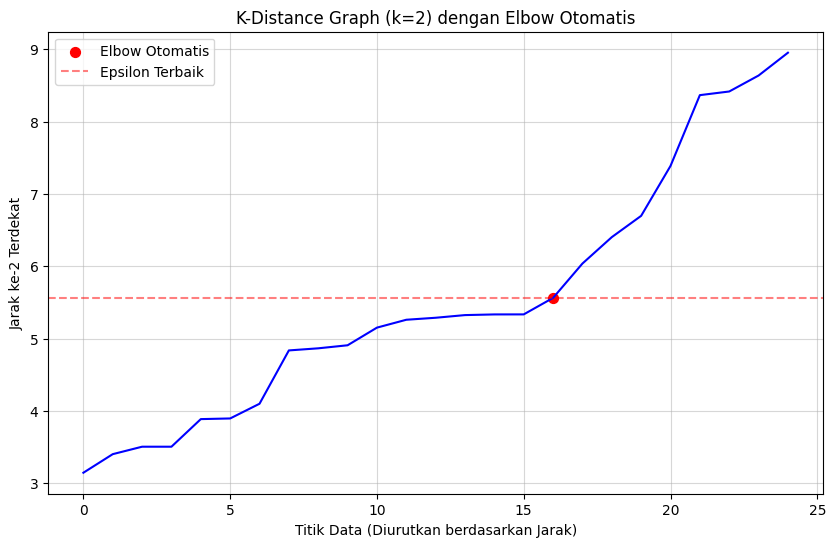

In [144]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler # Diasumsikan df_scaled adalah DataFrame atau numpy array
from kneed import KneeLocator

df = pd.read_excel("dataset/preprocessed_gabungan_komoditas.xlsx")
k = 2  # Nilai min_samples yang dipilih (ganti jika perlu)

X = df.drop("Kabupaten/Kota", axis=1)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Inisialisasi NearestNeighbors
# n_neighbors diatur ke k + 1 karena nearest neighbor pertama selalu titik itu sendiri (jarak 0)
neigh = NearestNeighbors(n_neighbors=k + 1) 
distances = neigh.fit(X_scaled).kneighbors()[0]

# Jarak ke-k terdekat adalah kolom ke-k (indeks k)
# Kita hanya ambil kolom ke-k (indeks k-1 karena kita mulai dari 0, atau k jika kita hitung titik diri sendiri)
# Karena kita pakai n_neighbors = k+1, jarak ke-k adalah kolom indeks k.
k_distances = distances[:, k]

# Urutkan jarak-jarak tersebut untuk plotting
k_distances = np.sort(k_distances, axis=0)

# Verifikasi: k_distances sekarang adalah array 1D dari jarak ke-k terdekat
kneedle = KneeLocator(
    range(len(k_distances)), 
    k_distances, 
    S=1.0, 
    curve='convex', 
    direction='increasing'
)

epsilon_otomatis = kneedle.knee_y

# Indeks titik belokan (pada sumbu X)
elbow_index = kneedle.knee

print(f"Nilai Epsilon (Elbow) Otomatis: {epsilon_otomatis:.4f}")

# Opsional: Tambahkan penanda ke plot Anda
plt.figure(figsize=(10, 6))
plt.plot(k_distances, linestyle='-', color='blue')
# Tandai titik elbow
plt.scatter(elbow_index, epsilon_otomatis, color='red', s=50, label='Elbow Otomatis')
plt.axhline(y=epsilon_otomatis, color='r', linestyle='--', alpha=0.5, label='Epsilon Terbaik')
plt.title(f'K-Distance Graph (k={k}) dengan Elbow Otomatis')
plt.xlabel('Titik Data (Diurutkan berdasarkan Jarak)')
plt.ylabel(f'Jarak ke-{k} Terdekat')
plt.legend()
plt.grid(True, alpha=0.5)
plt.show()

In [145]:
epsilon_otomatis = round(epsilon_otomatis, 2)
print(epsilon_otomatis)

5.56


### Hasil Eksperimen DBSCAN (Top 10) ###
      eps  min_samples  n_clusters  n_noise  silhouette       dbi  runtime_sec
450  6.06            2           2        3    0.481834  0.677121     0.004272
451  6.06            3           2        3    0.481834  0.677121     0.003788
459  6.11            2           2        3    0.481834  0.677121     0.004730
460  6.11            3           2        3    0.481834  0.677121     0.004446
468  6.16            2           2        3    0.481834  0.677121     0.003556
469  6.16            3           2        3    0.481834  0.677121     0.004780
432  5.96            2           2        4    0.474911  0.632397     0.003912
441  6.01            2           2        4    0.474911  0.632397     0.004022
477  6.21            2           2        2    0.468245  0.694883     0.004825
478  6.21            3           2        2    0.468245  0.694883     0.004522

Best Parameters: eps=6.059999999999991, min_samples=2
=== ANGGOTA CLUSTER untuk n_cluster

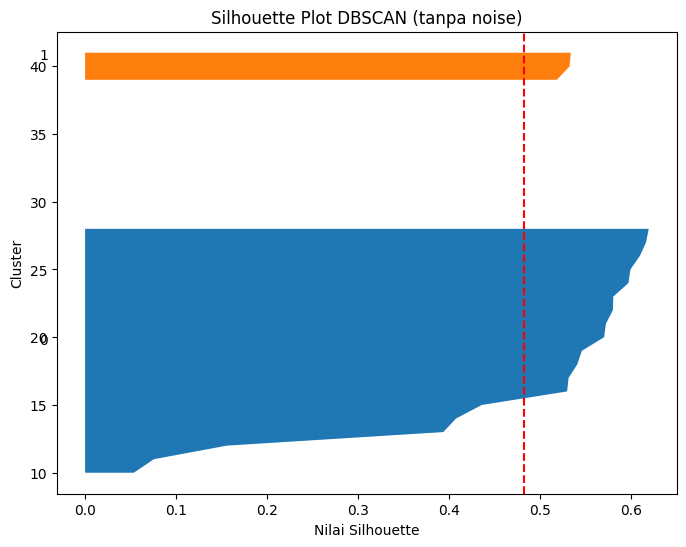

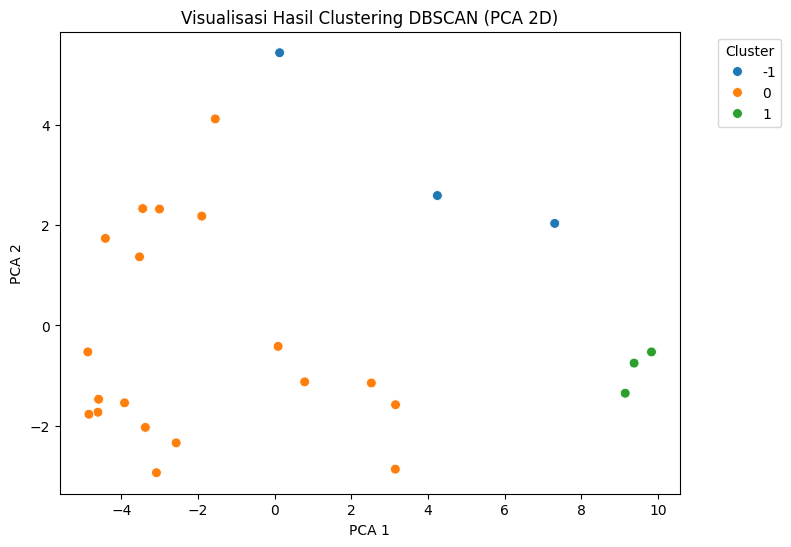

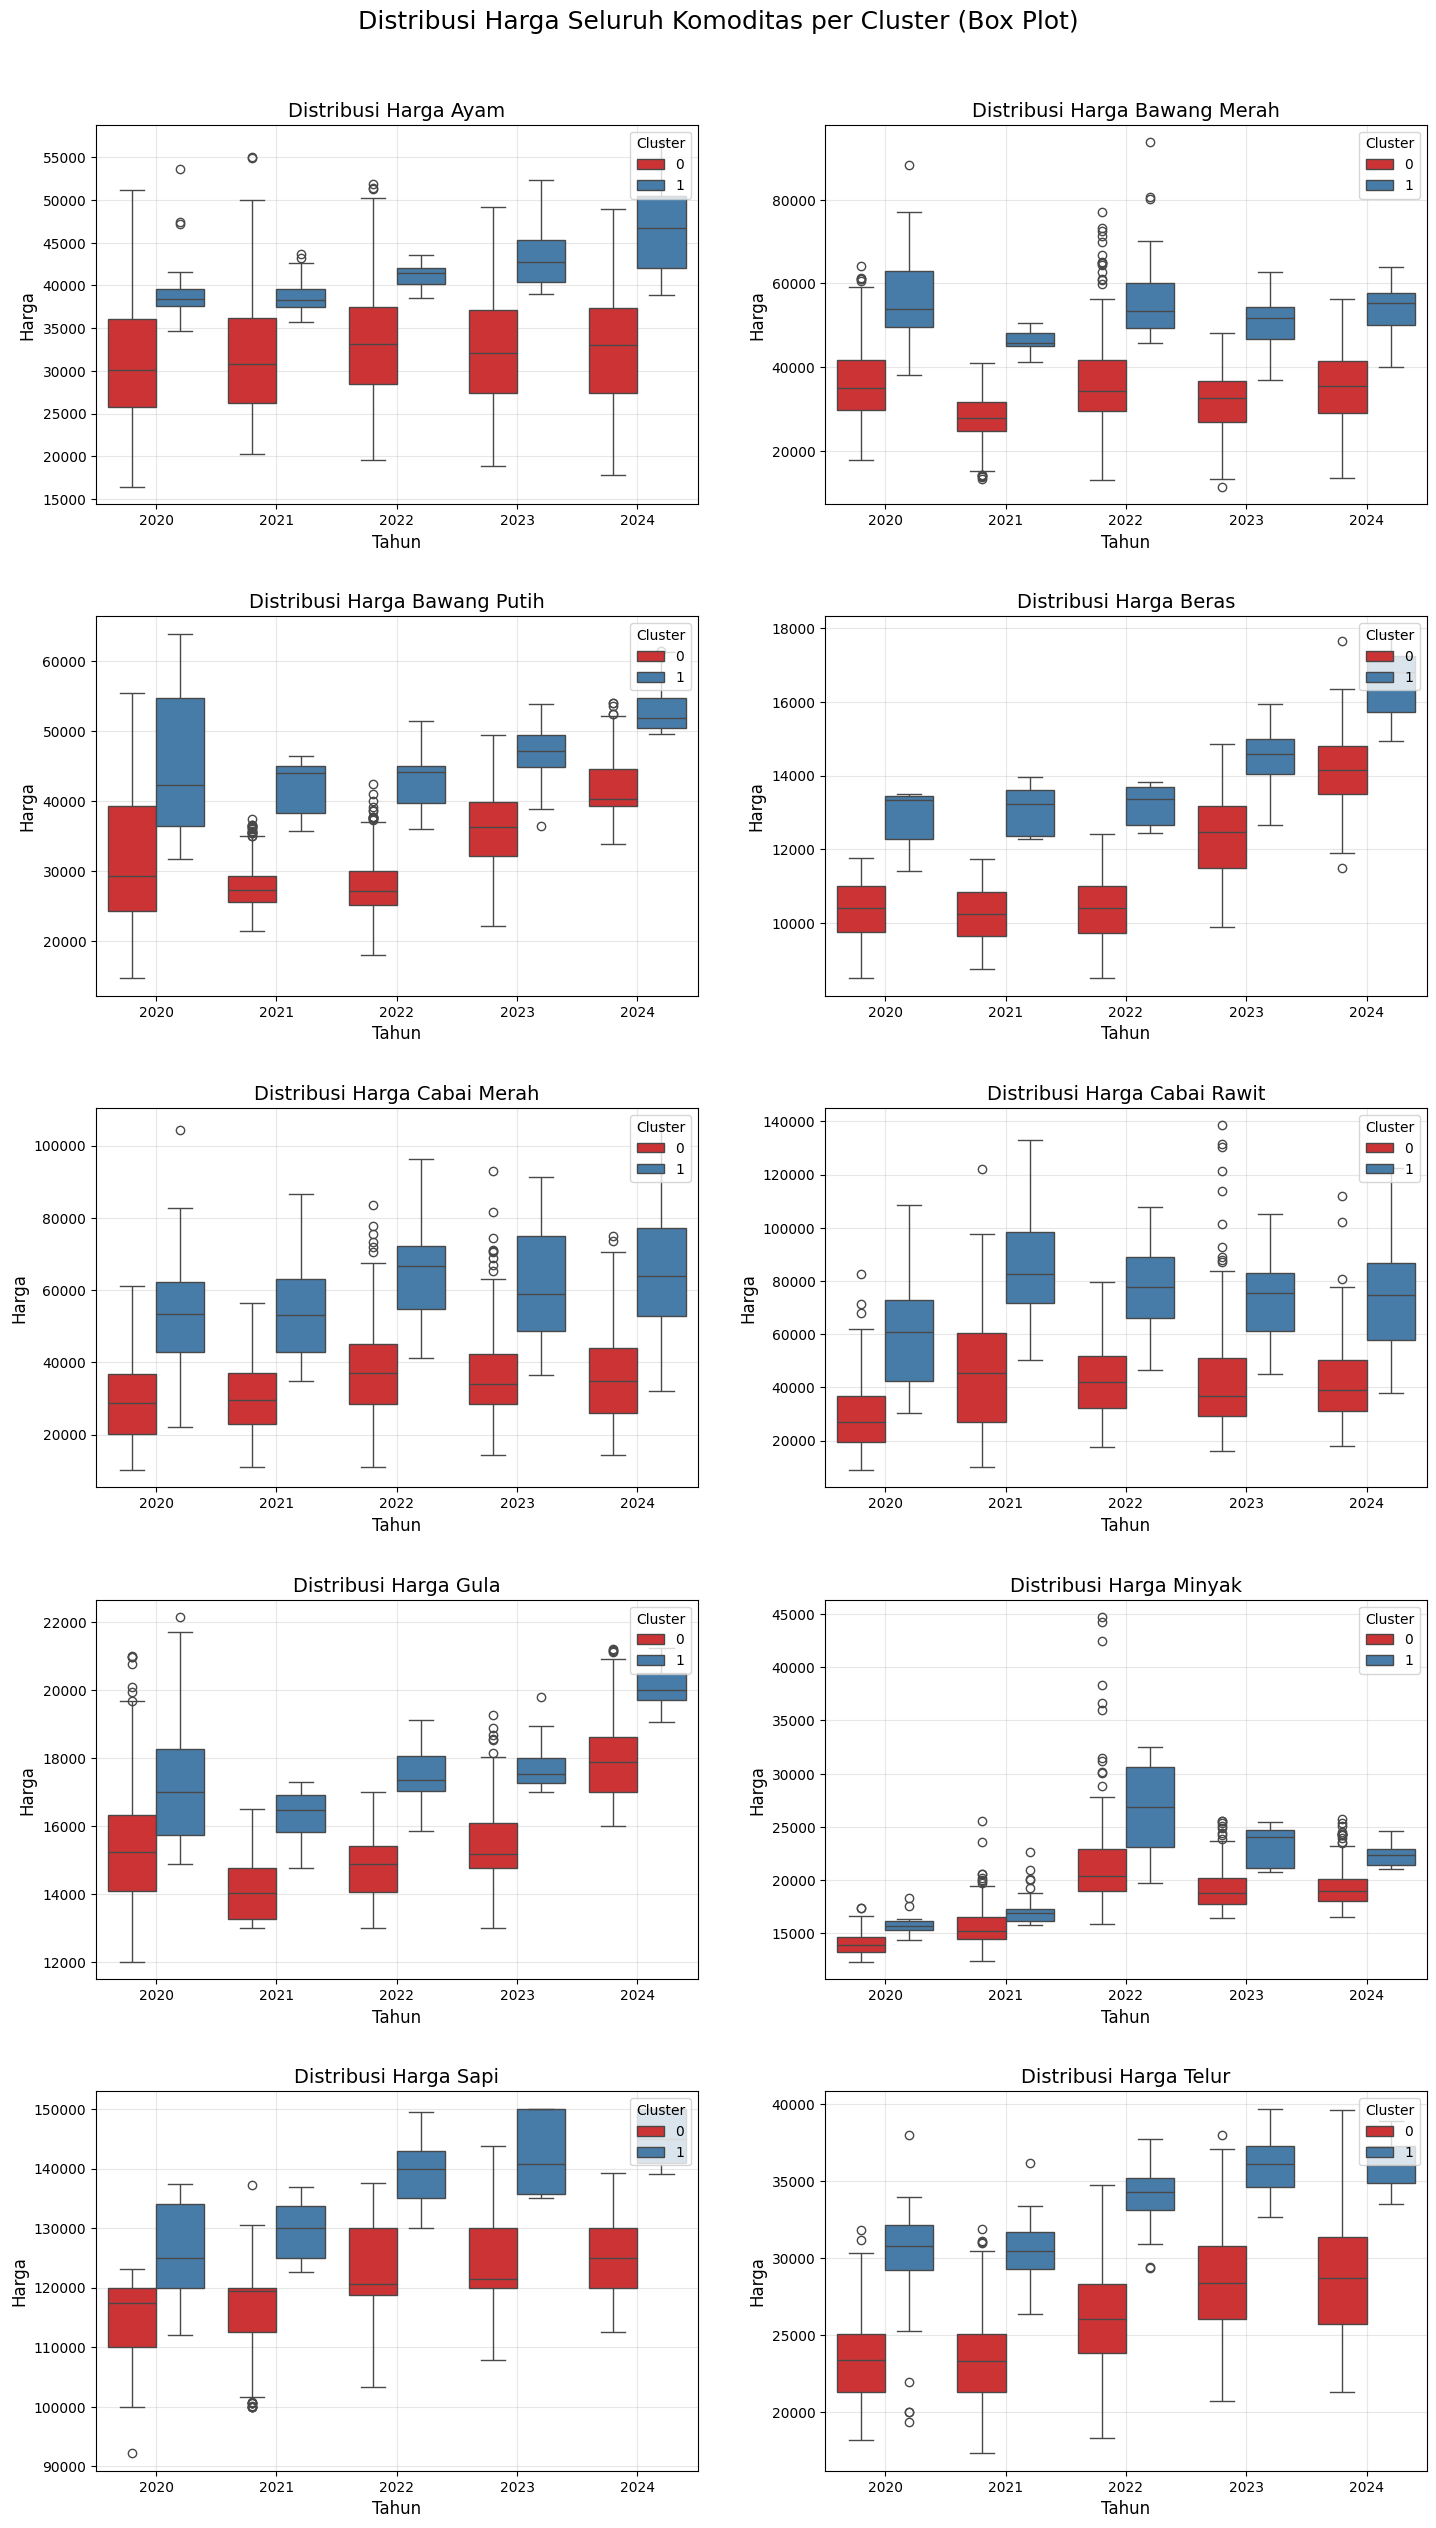

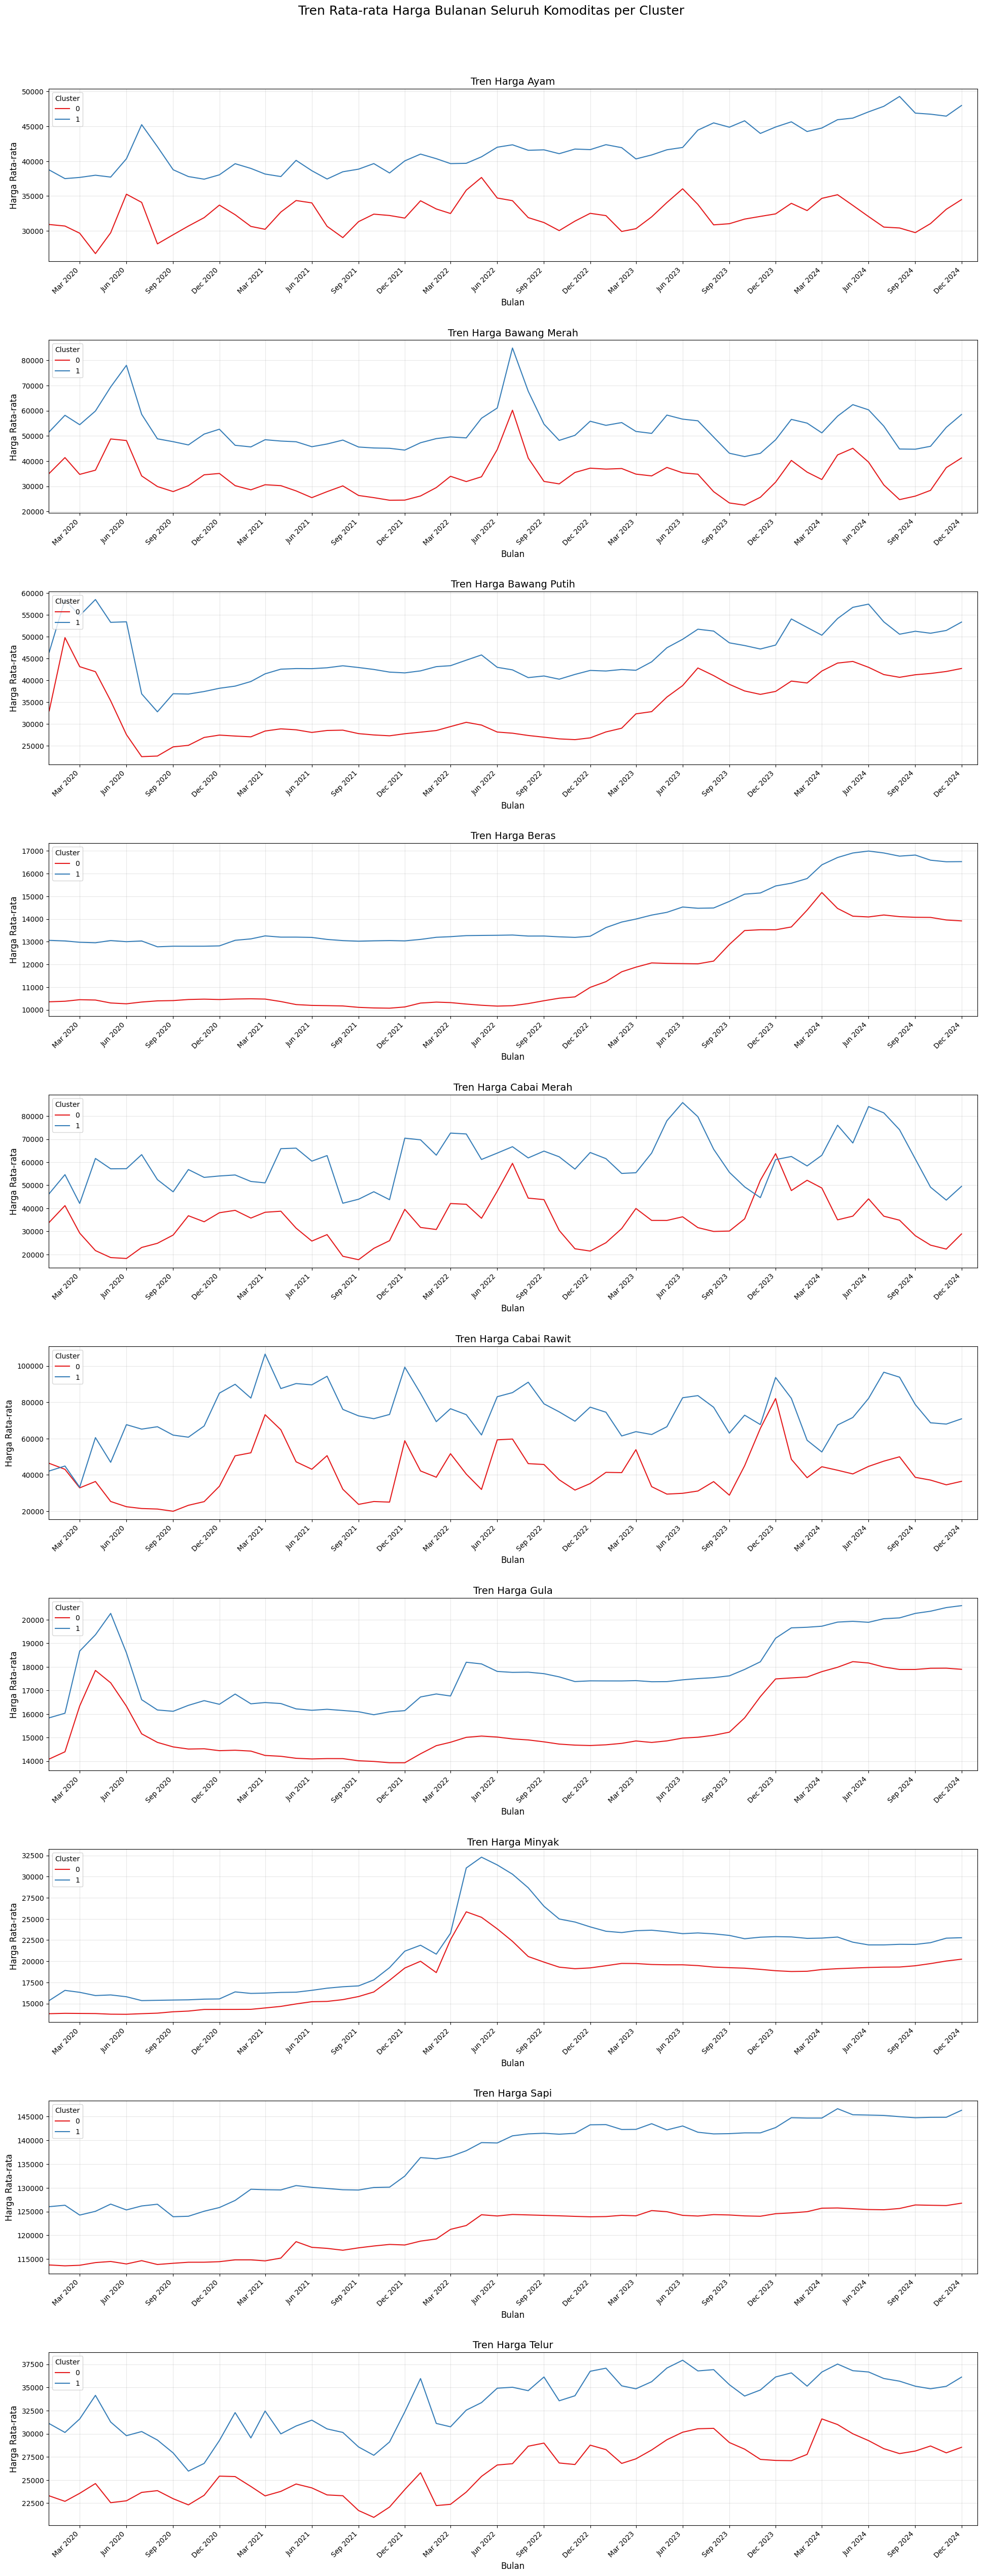

In [146]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, silhouette_samples
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.decomposition import PCA

df = pd.read_excel("dataset/preprocessed_gabungan_komoditas.xlsx")
df = df.rename(columns={"kabupaten/kota": "Kabupaten/Kota"})
# print(df.head())

# --- PREPROCESSING ---
X = df.drop("Kabupaten/Kota", axis=1)

# Gunakan RobustScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
feature_names = df.drop("Kabupaten/Kota", axis=1).columns

# --- PARAMETER GRID ---
param_grid = {
    "eps": np.arange(epsilon_otomatis - 2, epsilon_otomatis + 2, 0.05),
    "min_samples": list(range(2, 11))
}
results = []

# --- GRID SEARCH DBSCAN ---
for eps in param_grid["eps"]:
    for min_samples in param_grid["min_samples"]:
        start_time = time.time()
        model = DBSCAN(eps=eps, min_samples=min_samples)
        labels = model.fit_predict(X_scaled)

        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = np.sum(labels == -1)

        if n_clusters > 1:
            mask = labels != -1
            X_masked = X_scaled[mask]
            labels_masked = labels[mask]

            sil_score = silhouette_score(X_masked, labels_masked)
            dbi = davies_bouldin_score(X_masked, labels_masked)

            # # label cluster
            # df_clustered = df[['Kabupaten/Kota']].copy()
            # df_clustered['Cluster'] = labels 

            # print(f"=== ANGGOTA CLUSTER untuk n_clusters = {n_clusters} ===")
            # df_clustered_sorted = df_clustered.sort_values(by='Cluster')
            # print(df_clustered_sorted)

        else:
            sil_score = -1
            dbi = np.inf

        

        runtime = time.time() - start_time
        results.append({
            "eps": eps,
            "min_samples": min_samples,
            "n_clusters": n_clusters,
            "n_noise": n_noise,
            "silhouette": sil_score,
            "dbi": dbi,
            "runtime_sec": runtime
        })

# --- HASIL EKSPERIMEN ---
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by=["silhouette", "dbi", "n_noise"], ascending=[False, True, True])
print("### Hasil Eksperimen DBSCAN (Top 10) ###")
print(results_df.head(10))

# --- AMBIL PARAMETER TERBAIK ---
best_params = results_df.iloc[0]
best_eps = best_params["eps"]
best_min_samples = int(best_params["min_samples"])
print(f"\nBest Parameters: eps={best_eps}, min_samples={best_min_samples}")

# --- FIT MODEL TERBAIK ---
best_model = DBSCAN(eps=best_eps, min_samples=best_min_samples)
labels = best_model.fit_predict(X_scaled)

# label cluster
df_clustered = df[['Kabupaten/Kota']].copy()
df_clustered['Cluster'] = labels 
best_cluster = best_params["n_clusters"]

print(f"=== ANGGOTA CLUSTER untuk n_clusters = {n_clusters} ===")
df_clustered_sorted = df_clustered.sort_values(by='Cluster')
print(df_clustered_sorted)
df_clustered_sorted.to_excel("cluster.xlsx", index=False)

# --- SILHOUETTE VISUALIZATION ---
mask = labels != -1
X_masked = X_scaled[mask]
labels_masked = labels[mask]

if len(np.unique(labels_masked)) > 1:
    silhouette_vals = silhouette_samples(X_masked, labels_masked)
    cluster_labels = np.unique(labels_masked)
    n_clusters = cluster_labels.shape[0]
    
    y_lower = 10
    plt.figure(figsize=(8, 6))
    for i, c in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[labels_masked == c]
        c_silhouette_vals.sort()
        y_upper = y_lower + len(c_silhouette_vals)
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, c_silhouette_vals)
        plt.text(-0.05, y_lower + 0.5 * len(c_silhouette_vals), str(c))
        y_lower = y_upper + 10
    plt.axvline(x=np.mean(silhouette_vals), color="red", linestyle="--")
    plt.title("Silhouette Plot DBSCAN (tanpa noise)")
    plt.xlabel("Nilai Silhouette")
    plt.ylabel("Cluster")
    plt.show()

# --- SCATTER PLOT CLUSTERING (PCA 2D) ---
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels, palette="tab10", s=50)
plt.title("Visualisasi Hasil Clustering DBSCAN (PCA 2D)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

# --- BOXPLOT PER FITUR UNTUK SETIAP CLUSTER ---
df_visualized_base = pd.DataFrame(
    X_scaled,
    columns=X.columns # Gunakan nama kolom fitur asli
)

df_visualized = df.copy()
df_visualized = df_visualized.merge(df_clustered, on="Kabupaten/Kota", how="inner")
plot_all_commodities_boxplot(df_visualized)
plot_all_commodities_lineplot(df_visualized)

In [147]:
import folium
from IPython.display import display
import pandas as pd
import os

MAP_OUTPUT_DIR = "misc/map/dbscan"

# 💡 PENAMBAHAN BARU: Membuat direktori output jika belum ada
try:
    os.makedirs(MAP_OUTPUT_DIR, exist_ok=True)
    print(f"Folder output '{MAP_OUTPUT_DIR}' sudah siap.")
except Exception as e:
    print(f"Gagal membuat folder: {e}. Periksa izin atau path.")

df_map = pd.read_csv("misc/mapping.csv", delimiter=',')
df_merged = None


    
# Menampilkan contoh data dari hasil clustering
print(f"\n-------------- Hasil Cluster untuk K = {k} --------------------")
# print(df_result.head())


# df_merged = df_all.merge(df_result, on="Kabupaten/Kota", how="right")
# df_merged['Kabupaten/Kota'] = df_merged['Kabupaten/Kota'].str.strip()
df_merged = df_clustered.merge(df_map, on="Kabupaten/Kota", how="inner")
df_merged['Cluster'] = df_merged['Cluster'].astype(str)
print(df_merged.head(10))

map = folium.Map(location=[-4.00,130.00], zoom_start=5)

color_map = {'0': 'blue', '1': 'green', '2': 'red', '-1': 'gray', '3': 'purple', '4': 'orange', '5': 'darkred', '6': 'lightblue', '7': 'beige', '8': 'darkgreen', '9': 'white'}

for index, row in df_merged.iterrows():
    cluster_label = row['Cluster']

    # print(cluster_label)
    popup_text = f"""
        <b>{row['Kabupaten/Kota']}</b><br>
        Cluster: <b>{cluster_label}</b>
    """

    marker_color = color_map.get(cluster_label, 'black') # Default hitam


    # Pastikan df_map memiliki kolom 'Latitude', 'Longitude', dan 'Kabupaten/Kota'
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        tooltip=row['Kabupaten/Kota'],
        popup=folium.Popup(popup_text, max_width=300), # Gunakan folium.Popup untuk styling
        icon=folium.Icon(color=marker_color) # Tambahkan ikon berwarna
    ).add_to(map)

file_name = os.path.join(MAP_OUTPUT_DIR, f"peta_cluster_dbscan.html")
map.save(file_name) 
display(map)

    

Folder output 'misc/map/dbscan' sudah siap.

-------------- Hasil Cluster untuk K = 2 --------------------
         Kabupaten/Kota Cluster             Provinsi  Latitude  Longitude
0        Kab. Bulukumba       0     Sulawesi Selatan   -5.3912   120.2559
1     Kab. Lombok Timur       0  Nusa Tenggara Barat   -8.6500   116.5300
2           Kab. Majene       0       Sulawesi Barat   -3.5510   119.0069
3        Kab. Manokwari       1          Papua Barat   -0.8616   134.0622
4          Kab. Merauke      -1        Papua Selatan   -8.4716   140.3807
5  Kab. Polewali Mandar       0       Sulawesi Barat   -3.4285   119.3491
6          Kab. Sumbawa       0  Nusa Tenggara Barat   -8.5833   117.3333
7          Kota Bau-Bau       0    Sulawesi Tenggara   -5.4620   122.6288
8             Kota Bima       0  Nusa Tenggara Barat   -8.4770   118.7300
9         Kota Denpasar       0                 Bali   -8.6556   115.2162
